In [6]:
from evals_header import *
pd.set_option('display.max_rows', 200)
T = 0.9

def read_sweep(sweep_fn):
    sweep_df = pd.read_csv(sweep_fn, sep='\t', header=None)
    sweep_df.columns = ['query_name', 'k', 'P_sz','p_sz', 'matches', 'ref_start', 'ref_end', 'minx', 'J', 'runtime']
    sweep_df['J'] = sweep_df['J'].round(3)
    sweep_df['alignment_bps'] = sweep_df['ref_end'] - sweep_df['ref_start']
    return sweep_df

def add_TP_column(tested_df, groundtruth_df, TP_column_name):
    tested_df[TP_column_name] = tested_df.apply(lambda row: get_max_jaccard(row, groundtruth_df) >= T, axis=1)

def get_sensitivity(tested_df, truth_df):
    add_overlap_column(tested_df, truth_df, 'TP')
    add_overlap_column(truth_df, tested_df, 'TP')

    sensitivity = tested_df['TP'].sum() / tested_df.shape[0]  # TP / P
    specificity = truth_df['TP'].sum() / truth_df.shape[0]  # 1 - FP / N 

    display(tested_df.head())
    display(truth_df.head())

    #correct = df[df['overlap'] > 0.1].shape[0]
    #all = df.shape[0]
    #accuracy = correct / all
    #return correct, all, accuracy

In [52]:
#def plot_time_hist(df):
#    plt.figure(figsize=(10, 6))
#    #plt.hist(df["runtime"], cumulative=True, bins=20, log=True)
#    plt.hist(df["runtime"], bins=20, cumulative=True, color='green', alpha=0.7, weights=df["runtime"])
#    plt.xlabel("Runtime")
#    plt.ylabel("Cumulative Runtime")
#    plt.title("Histogram of Runtime with Cumulative Runtime on Y-axis (Logarithmic X-axis)")
#    plt.xscale("log")
#    plt.show()

def plot_time_hist(df):
    df_sorted = df.sort_values(by='runtime')

    # Calculate the cumulative sum
    cumulative_sum = df_sorted['runtime'].cumsum()
    display(cumulative_sum.head())
    display(cumulative_sum.tail())

    # Convert to NumPy arrays
    runtime_array = df_sorted['runtime'].to_numpy()
    cumulative_sum_array = cumulative_sum.to_numpy()
    #print('total time: ', cumulative_sum_array[-1])

    # Create the line plot
    #plt.plot(runtime_array, cumulative_sum_array)

    # Add red dots for each data point
    plt.scatter(runtime_array, cumulative_sum_array)

    # Labeling the axes
    plt.xlabel('Runtime (seconds)')
    plt.ylabel('Cumulative Sum of Runtimes')
    plt.title('Cumulative Sum of Runtimes')

    # Adjusting the scale if necessary
    plt.xscale('log')  # Use logarithmic scale if the range of runtimes is large

    # Show the plot
    plt.show()

In [57]:
# Input
reads_fn = 'simulations/reads/t2thumanChrY_sr0.0001090909090909091_dr0.0009818181818181818_i0.0009090909090909091_sd7361077429744071834_lmn100_lmx1000000_lavg9000_ls7000_dp10_rm20.fasta'
#eskemap_fn = 'out/eske100.out'
minimap_fn = 'out/minimap.out'
#sweep_fn = 'sweep-pairs-noblacklist.out'
#sweep_fn = 'out/sweep-b-a-fine.out'
#sweep_fn = 'sweep-normalized-intervals.out'

# Minimap
minimap_df = pd.read_csv(minimap_fn, sep='\t', header=None)
minimap_df.columns = ['query_name', 'query_len', 'query_start', 'query_end', 'strand', 'ref_name', 'ref_len', 'ref_start', 'ref_end', 'match_bases', 'total_bases', 'map_quality', 'cigar']

# Simulated reads
simulated_df = parse_fasta_metadata(reads_fn)

sweep_dfs = {}
params_dfs = pd.DataFrame()
# all files in which start with "sweep_"
for sweep_fn in glob.glob('out/sweep*.out'):
    print(sweep_fn)
    sweep_dfs[sweep_fn] = read_sweep(sweep_fn)
    sweep_dfs[sweep_fn] = pd.merge(simulated_df, sweep_dfs[sweep_fn], on='query_name', how='left')
    add_overlap_column(sweep_dfs[sweep_fn], minimap_df, 'overlap')
    correct, all, accuracy = get_accuracy(sweep_dfs[sweep_fn])
    # sensitivity = get_sensitivity(sweep_dfs[sweep_fn], minimap_df)
    # change the extension to '.params'
    continue
    params_fn = sweep_fn.replace('.out', '.params')
    params_df = pd.read_csv(params_fn, sep='\t')
    params_df['correct'], params_df['all'],params_df['accuracy'] = correct, all, accuracy
    #print('{} {:.2%} ({} / {})'.format(sweep_fn, accuracy, correct, all))
    params_dfs = pd.concat([params_dfs, params_df], axis=0)
# Sweep algo
display(params_dfs)

# Eskemap
#eskemap_df = pd.read_csv(eskemap_fn, sep='\t', header=None)
#eskemap_df.columns = ['query_name', 'ref_start', 'ref_end', 'jaccard_scoreX1000']

out/sweep-x.out


""


In [58]:
# Output
for fn, df in sweep_dfs.items():
    # sort df decreasingly by 'runtime' column
    df = df.sort_values(by='runtime', ascending=False)
    display(df.head(10))
    display(df.tail(10))

,query_name,from_ref_sim,to_ref_sim,read_len,k,P_sz,p_sz,matches,ref_start,ref_end,minx,J,runtime,alignment_bps,overlap
3262,s_3262,11510282,11512960,2678,15,2677,498,191656,11510296,11512968,474,0.905,0.019453,2672,0.992182
168,s_168,42919487,42941302,21815,15,21810,4107,101943,42919501,42941316,419,0.054,0.017823,21815,0.998763
6542,s_6542,49927431,49953259,25828,15,25822,4973,102536,49927445,49955605,775,0.085,0.016207,28160,0.916270
2616,s_2616,45533659,45569589,35930,15,35925,6957,100662,45533673,45570195,975,0.075,0.016202,36522,0.983058
5462,s_5462,50080645,50127983,47338,15,47340,9209,101854,50080659,50127982,668,0.038,0.016108,47323,0.999662
6415,s_6415,43475354,43497574,22220,15,22221,4313,100686,43475368,43498194,747,0.095,0.016071,22826,0.972285
1745,s_1745,43536699,43561272,24573,15,24563,4738,102929,43536712,43562028,762,0.087,0.015824,25316,0.969679
6788,s_6788,59413059,59440570,27511,15,27512,5333,100299,59413074,59440570,665,0.067,0.015770,27496,0.999418
6691,s_6691,60731813,60752958,21145,15,21145,4094,100708,60731827,60752958,692,0.093,0.015739,21131,0.999291
6835,s_6835,56346563,56372543,25980,15,25979,5086,102675,56346577,56372814,630,0.066,0.015707,26237,0.989181


,query_name,from_ref_sim,to_ref_sim,read_len,k,P_sz,p_sz,matches,ref_start,ref_end,minx,J,runtime,alignment_bps,overlap
5022,s_5022,15756845,15757279,434,15,434,76,81,15756859,15757279,72,0.878,0.000034,420,0.965517
300,s_300,27124604,27124980,376,15,377,60,65,27124618,27124980,56,0.889,0.000033,362,0.960212
4917,s_4917,16113815,16114233,418,15,420,81,84,16113829,16114233,72,0.800,0.000032,404,0.964200
5167,s_5167,13249582,13249925,343,15,345,60,97,13249596,13249925,59,0.967,0.000031,329,0.956395
4146,s_4146,14407798,14408090,292,15,295,49,58,14407812,14408090,44,0.830,0.000027,278,0.948805
2267,s_2267,17326638,17326854,216,15,218,37,73,17071604,17071806,34,0.850,0.000026,202,0.895928
3024,s_3024,19515729,19515900,171,15,172,26,96,19515743,19515900,26,1.000,0.000019,157,0.912791
5092,s_5092,21226745,21226928,183,15,184,31,41,21226759,21226928,31,1.000,0.000015,169,0.918478
747,s_747,8313960,8314105,145,15,146,21,29,8313974,8314105,21,1.000,0.000011,131,0.897260
552,s_552,5536109,5536219,110,15,111,19,20,5536123,5536219,19,1.000,0.000011,96,0.864865


  out/sweep-x.out           unique reads=6941  mean overlap=95.87%
  total runtime:  46.921611


552     0.000011
747     0.000022
5092    0.000037
3024    0.000056
2267    0.000082
Name: runtime, dtype: float64

5462    46.851926
2616    46.868128
6542    46.884335
168     46.902158
3262    46.921611
Name: runtime, dtype: float64

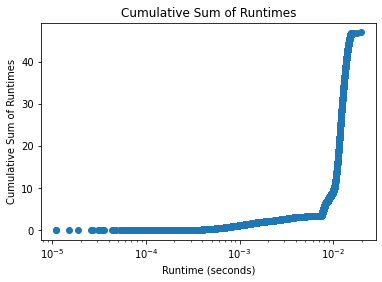

In [59]:
# loop for each sweep df
for fn, df in sweep_dfs.items():
    print('  {:<25} unique reads={:<5} mean overlap={:.2%}'.format(fn, len(df['query_name'].unique()), df['overlap'].mean()))
    print('  total runtime: ', df['runtime'].sum())
    plot_time_hist(df)
#print('  Sweep avg overlap: {:.8}'.format(sweep_df['overlap'].mean()))
#sweep_df.to_csv('out/all.csv', sep='\t', index=False)
#plot_all_columns(sweep_df)

In [62]:
sweep_df = sweep_dfs['out/sweep-Y-x.out']
sweep_misaligned_df = sweep_df[sweep_df['overlap'] < 0.1]
sweep_misaligned_df = sweep_misaligned_df[sweep_misaligned_df['overlap'] >= 0]  # remove reads not aligned by minimap
sweep_misaligned_df['start_diff'] = sweep_misaligned_df['ref_start'] - sweep_misaligned_df['from_ref_sim']

display(sweep_misaligned_df[sweep_misaligned_df['start_diff'] > 0].head(10))

print('Number of misaligned reads:', sweep_misaligned_df.shape[0])
sweep_misaligned_df.to_csv('out/misalignments.csv', sep='\t', index=False)
#plot_all_columns(sweep_misaligned_df)
display(sweep_misaligned_df.head(10))    

KeyError: 'out/sweep-Y-x.out'